# Calculate the accumulated difference in calls to shared libraries

In this Jupyter notebook, we will be analysing the number of calls to shared libraries during subcortical segmentation (FSL FIRST).
The pipeline will include a plot of accumulated difference.

## Inputs
- A logfile of calls to shared library by ltrace.
- A log summary of all the calls.

## Outputs
- Plot of accumulation of difference.

## Notebook Workflow
1. Iterate through each logfile and log summary.
2. Compare the sequence in each logfile by called functions, keep count for the number of mismatch between two sequences.
3. Generate plot

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.ticker import ScalarFormatter
from matplotlib.lines import Line2D

In [2]:
!unzip './data/*.zip'

PATH_TO_LOGFILE_LOCAL_A = './local_system_A/logfile_local_A.txt'
PATH_TO_LOGSUMMARY_LOCAL_A = './local_system_A/summary_fsl_first_local_A.txt'

PATH_TO_LOGFILE_LOCAL_B = './local_system_B/logfile_local_B.txt'
PATH_TO_LOGSUMMARY_LOCAL_B = 'local_system_B/summary_fsl_first_local_B.txt'

PATH_TO_LOGFILE_NEURODESK_A = './neurodesk_system_A/logfile_neurodesk_A.txt'
PATH_TO_LOGSUMMARY_NEURODESK_A = './neurodesk_system_A/summary_fsl_first_neurodesk_A.txt'

PATH_TO_LOGFILE_NEURODESK_B = './neurodesk_system_B/logfile_neurodesk_B.txt'
PATH_TO_LOGSUMMARY_NEURODESK_B = 'neurodesk_system_B/summary_fsl_first_neurodesk_B.txt'


Archive:  ./data/local_system_A.zip
   creating: local_system_A/
  inflating: local_system_A/logfile_local_A.txt  
  inflating: local_system_A/summary_fsl_first_local_A.txt  

Archive:  ./data/neurodesk_system_A.zip
   creating: neurodesk_system_A/
  inflating: neurodesk_system_A/logfile_neurodesk_A.txt  
  inflating: neurodesk_system_A/summary_fsl_first_neurodesk_A.txt  

Archive:  ./data/neurodesk_system_B.zip
   creating: neurodesk_system_B/
  inflating: neurodesk_system_B/logfile_neurodesk_B.txt  
  inflating: neurodesk_system_B/summary_fsl_first_neurodesk_B.txt  

Archive:  ./data/local_system_B.zip
   creating: local_system_B/
  inflating: local_system_B/logfile_local_B.txt  
  inflating: local_system_B/summary_fsl_first_local_B.txt  

4 archives were successfully processed.


## Load trace log from Local System A

In [3]:
with open(os.path.join(PATH_TO_LOGSUMMARY_LOCAL_A)) as f:
    lines_sum = f.readlines()

uniquecalls_local_A=[]
for ii, line in enumerate(lines_sum):
    if ii>1:
        uniquecalls_local_A.append(line.split(" ")[-1].split("\n")[0])
uniquecalls_local_A.append('__libc_start_main')
uniquecalls_local_A.append('exit')
uniquecalls_local_A.append('+++')

with open(os.path.join(PATH_TO_LOGFILE_LOCAL_A)) as f:
    lines = f.readlines()

calls_local_A = []
for ii, line in enumerate(lines):
    call = line.split(' ')[1].split('(')[0]
    calls_local_A.append(uniquecalls_local_A.index(call))

## Load trace log from Local System B

In [4]:
with open(os.path.join(PATH_TO_LOGSUMMARY_LOCAL_B)) as f:
    lines_sum = f.readlines()

uniquecalls_local_B=[]
for ii, line in enumerate(lines_sum):
    if ii>1:
        uniquecalls_local_B.append(line.split(" ")[-1].split("\n")[0])
uniquecalls_local_B.append('+++')

newindex_local = []
for call in uniquecalls_local_B:        
    if np.isin(call, uniquecalls_local_A):    
        newindex_local.append(uniquecalls_local_A.index(call))
    else:
        newindex_local.append(uniquecalls_local_B.index(call)+1000)

with open(os.path.join(PATH_TO_LOGFILE_LOCAL_B)) as f:
    lines = f.readlines()

calls_local_B = []
for ii, line in enumerate(lines):
    call = line.split(' ')[1].split('(')[0]
    calls_local_B.append(newindex_local[uniquecalls_local_B.index(call)])

## Load trace log from Neurodesk System A

In [5]:
with open(os.path.join(PATH_TO_LOGSUMMARY_NEURODESK_A)) as f:
    lines_sum = f.readlines()

uniquecalls_neurodesk_A=[]
for ii, line in enumerate(lines_sum):
    if ii>1:
        uniquecalls_neurodesk_A.append(line.split(" ")[-1].split("\n")[0])
uniquecalls_neurodesk_A.append('__libc_start_main')
uniquecalls_neurodesk_A.append('exit')
uniquecalls_neurodesk_A.append('+++')

with open(os.path.join(PATH_TO_LOGFILE_NEURODESK_A)) as f:
    lines = f.readlines()

calls_neurodesk_A = []
for ii, line in enumerate(lines):
    call = line.split(' ')[1].split('(')[0]
    calls_neurodesk_A.append(uniquecalls_neurodesk_A.index(call))

## Load trace log from Neurodesk System B

In [6]:
with open(os.path.join(PATH_TO_LOGSUMMARY_NEURODESK_B)) as f:
    lines_sum = f.readlines()

uniquecalls_neurodesk_B=[]
for ii, line in enumerate(lines_sum):
    if ii>1:
        uniquecalls_neurodesk_B.append(line.split(" ")[-1].split("\n")[0])
uniquecalls_neurodesk_B.append('+++')

newindex_neurodesk = []
for call in uniquecalls_neurodesk_B:        
    if np.isin(call, uniquecalls_neurodesk_A):    
        newindex_neurodesk.append(uniquecalls_neurodesk_A.index(call))
    else:
        newindex_neurodesk.append(uniquecalls_neurodesk_B.index(call)+1000)

with open(os.path.join(PATH_TO_LOGFILE_NEURODESK_B)) as f:
    lines = f.readlines()

calls_neurodesk_B = []
for ii, line in enumerate(lines):
    call = line.split(' ')[1].split('(')[0]
    calls_neurodesk_B.append(newindex_neurodesk[uniquecalls_neurodesk_B.index(call)])

# COMPARE

In [7]:
calls__local_np_A = np.array(calls_local_A)
calls__local_np_B = np.array(calls_local_B)

# Exclude floorf 
calls__local_np_floorless_A = calls__local_np_A[calls__local_np_A != 0]
calls__local_np_floorless_B = calls__local_np_B[calls__local_np_B != 0]

In [8]:
calls__neurodesk_np_A = np.array(calls_neurodesk_A)
calls__neurodesk_np_B = np.array(calls_neurodesk_B)

# Exclude floorf 
calls__neurodesk_np_floorless_A = calls__neurodesk_np_A[calls__neurodesk_np_A != 0]
calls__neurodesk_np_floorless_B = calls__neurodesk_np_B[calls__neurodesk_np_B != 0]

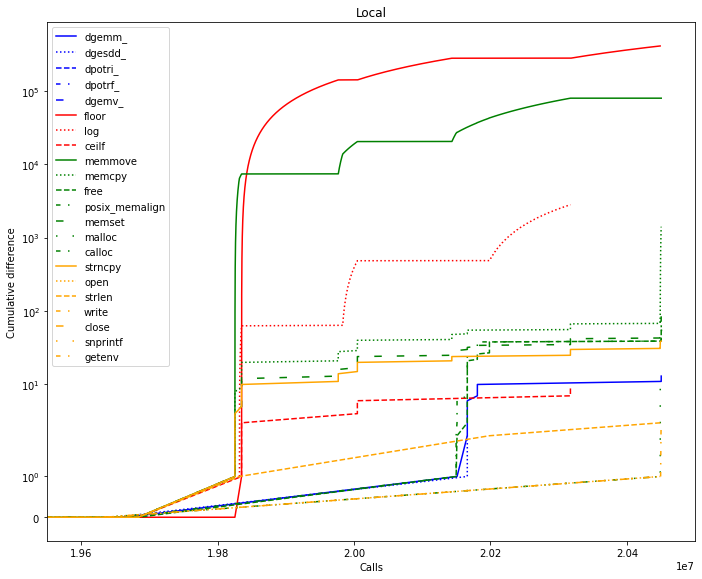

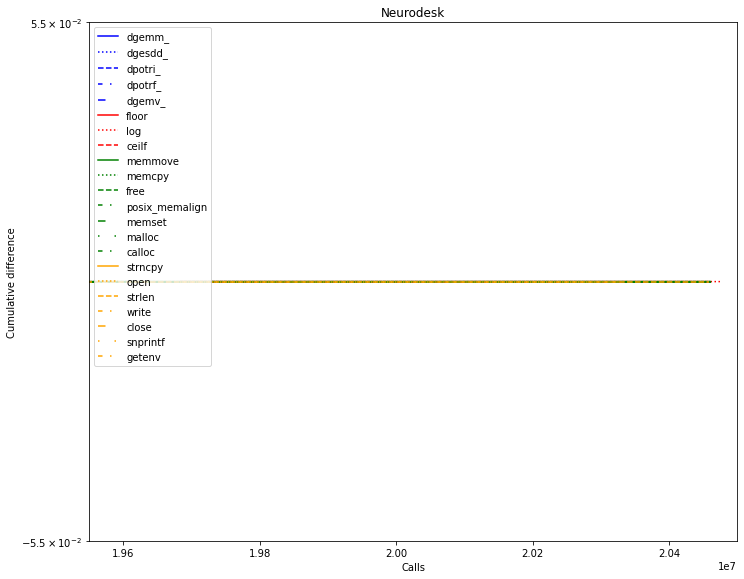

In [9]:
def line_plot(system_A, system_B, title):
    fig = plt.figure()
    ax = fig.add_axes([0.15, 0.1, 1.5, 1.8])  
    linestyle_tuple = [
        ('loosely dotted',        (0, (1, 10))),
        ('dotted',                (0, (1, 1))),
        ('densely dotted',        (0, (1, 1))),

        ('loosely dashed',        (0, (5, 10))),
        ('dashed',                (0, (5, 5))),
        ('densely dashed',        (0, (5, 1))),

        ('loosely dashdotted',    (0, (3, 10, 1, 10))),
        ('dashdotted',            (0, (3, 5, 1, 5))),
        ('densely dashdotted',    (0, (3, 1, 1, 1))),

        ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
        ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
        ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

    linestyle = ['-', ':', '--', (0, (3, 5, 1, 5)),(0, (5, 10)), (0, (1, 10)), (0, (3, 5, 1, 5, 1, 5))]
    linecolor = ['blue', 'red', 'green', 'orange']
    for id, func in enumerate([8,12,39,44,80]):
        a2=np.where(system_A==func)[0]
        b2=np.where(system_B==func)[0]
        if len(a2) > len(b2):
            a2 = a2[:len(b2)]
        else:
            b2 = b2[:len(a2)]
        diff = np.cumsum(a2!=b2)
        diff[diff==0] = 0.001
        ax.plot(a2, diff, label='{}'.format(uniquecalls_local_A[func]).replace("__",""), linestyle=linestyle[id], color=linecolor[0])

    for id, func in enumerate([3, 16, 55]):
        a2=np.where(system_A==func)[0]
        b2=np.where(system_B==func)[0]
        if len(a2) > len(b2):
            a2 = a2[:len(b2)]
        else:
            b2 = b2[:len(a2)]
        diff = np.cumsum(a2!=b2)
        diff[diff==0] = 0.001
        ax.plot(a2, diff, label='{}'.format(uniquecalls_local_A[func]).replace("__",""), linestyle=linestyle[id], color=linecolor[1])

    for id, func in enumerate([4, 7, 9, 10, 27, 50, 75]):
        a2=np.where(system_A==func)[0]
        b2=np.where(system_B==func)[0]
        if len(a2) > len(b2):
            a2 = a2[:len(b2)]
        else:
            b2 = b2[:len(a2)]
        diff = np.cumsum(a2!=b2)
        diff[diff==0] = 0.001
        ax.plot(a2, diff, label='{}'.format(uniquecalls_local_A[func]).replace("__",""), linestyle=linestyle[id], color=linecolor[2])

    for id, func in enumerate([40,57,56,60,65,74,78]):
        a2=np.where(system_A==func)[0]
        b2=np.where(system_B==func)[0]
        if len(a2) > len(b2):
            a2 = a2[:len(b2)]
        else:
            b2 = b2[:len(a2)]
        diff = np.cumsum(a2!=b2)
        diff[diff==0] = 0.001
        ax.plot(a2, diff, label='{}'.format(uniquecalls_local_A[func]).replace("__",""), linestyle=linestyle[id], color=linecolor[3])        

    ax.legend(loc='upper left')
    ax.set_xlim(xmin=19550000, xmax=20500000)
    ax.set_yscale('symlog')
    ax.set_xlabel('Calls')
    ax.set_ylabel('Cumulative difference')
    ax.set_title(title)

line_plot(calls__local_np_floorless_A, calls__local_np_floorless_B, "Local")
line_plot(calls__neurodesk_np_floorless_A, calls__neurodesk_np_floorless_B, "Neurodesk")